<a href="https://colab.research.google.com/github/harshankbansal/pytorch-deep-learning/blob/main/lectures/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [30]:
torch.__version__

'2.8.0+cu126'

In [31]:
weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(1)
y = weight * X + bias
X[:5],y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [32]:
# split into train and test


In [33]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 40
Length of y_train: 40
Length of X_test: 10
Length of y_test: 10


In [34]:
def plot_data(X_train, y_train, X_test, y_test, prediction):
    plt.figure(figsize=(10, 7))
    plt.scatter(X_train, y_train, c="b", s=4, label="training data")
    plt.scatter(X_test, y_test, c="r", s=4, label="testing data")
    if prediction is not None:
        plt.scatter(X_test, prediction, c="g", s=6, label="prediction")

    plt.legend()

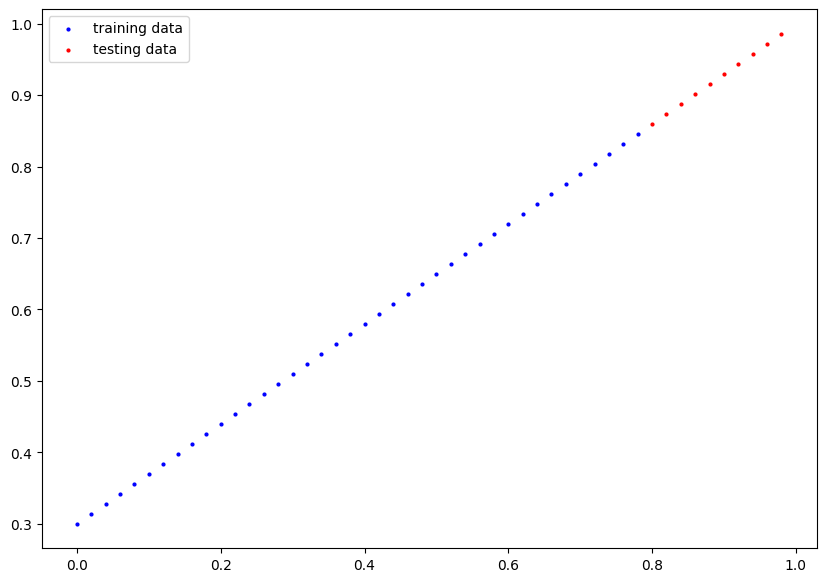

In [35]:
plot_data(X_train, y_train, X_test, y_test, None)

In [36]:
from typing_extensions import overload
### Create model
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bais = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bais

In [37]:
torch.manual_seed(42)
model_0 = LinearRegression()
list(model_0.named_parameters())

[('weights',
  Parameter containing:
  tensor([0.3367], requires_grad=True)),
 ('bais',
  Parameter containing:
  tensor([0.1288], requires_grad=True))]

In [38]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [39]:
#generate predictions
with torch.inference_mode():
  y_preds = model_0(X_test)

(y_preds,y_test)

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

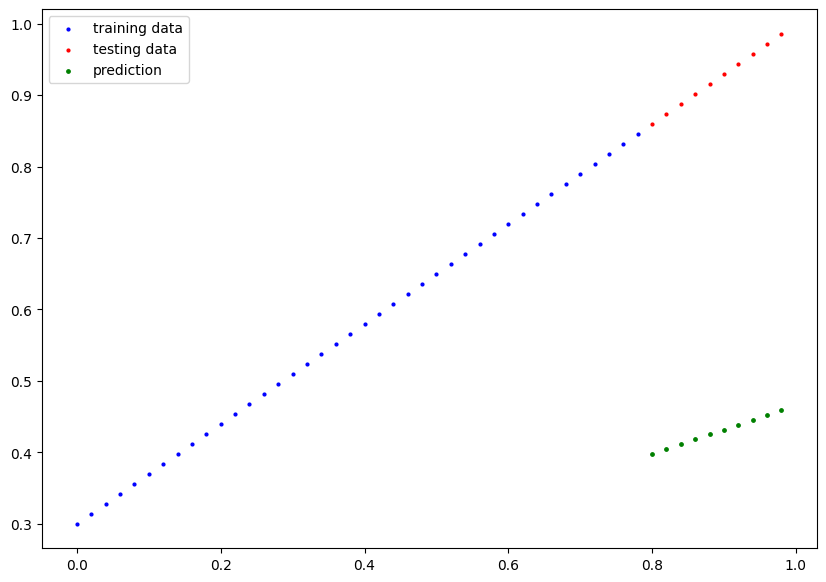

In [40]:
plot_data(X_train, y_train, X_test, y_test, y_preds)

In [ ]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    loss_fn=loss_fn,
    lr=0.01
)